In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline
import pickle
import pandas as pd
from tasks import wsd
from pathlib import Path
from tasks import wsd
from utils import nlp_tools
from tqdm.auto import tqdm
import numpy as np
import json
from sklearn.metrics import classification_report
from flair.embeddings import TransformerWordEmbeddings
from utils.dataset_download import harvest_data_from_extended_senses
from utils.classificaton_utils import binarize, vectorize_target_expressions,cosine_similiarity,eval_lemma

# Preparation

In [4]:
# import API credentials
with open('oed_experiments/oed_credentials.json') as f:
    auth = json.load(f)

In [5]:
# only run this once after downloading
# otherwise you remove the vectorized keywords
tqdm.pandas()
lemma,pos = 'machine', "NN"
#quotations = harvest_data_from_extended_senses(auth,f"{lemma}_{pos}")

# Vectorize data

In [5]:

quotations_path = "./data/sfrel_quotations_machine_NN.pickle"
embedding_methods = {'bert_base': {"path":'bert-base-uncased',
                                   'layers':'-1,-2,-3,-4',
                                   'pooling_operation':'mean'},
                     'blert': {"path":'/deezy_datadrive/kaspar-playground/bert_model/FT_bert_base_uncased_all_books_v002',
                                    'layers':'-1,-2,-3,-4',
                                    'pooling_operation':'mean'},
                     'bert_1850':{"path":"/datadrive/khosseini/LM_with_bert_MOVED_to_another_VM_REMOVE_FROM_NOVEMBER/models/bert/FT_bert_base_uncased_before_1850_v001", 
                                    'layers':'-1,-2,-3,-4',
                                    'pooling_operation':'mean'},
                      'bert_1900': {"path":"/datadrive/khosseini/LM_with_bert_MOVED_to_another_VM_REMOVE_FROM_NOVEMBER/models/bert/FT_bert_base_uncased_after_1890_before_1900_v002",
                                    'layers':'-1,-2,-3,-4',
                                    'pooling_operation':'mean'},
                      'bert_1875': {"path":"/datadrive/khosseini/LM_with_bert_MOVED_to_another_VM_REMOVE_FROM_NOVEMBER/models/bert/FT_bert_base_uncased_after_1850_before_1875_v002",
                                    'layers':'-1,-2,-3,-4',
                                    'pooling_operation':'mean'},
                      'bert_1890': {"path":"/datadrive/khosseini/LM_with_bert_MOVED_to_another_VM_REMOVE_FROM_NOVEMBER/models/bert/FT_bert_base_uncased_after_1875_before_1890_v002",
                                    'layers':'-1,-2,-3,-4',
                                    'pooling_operation':'mean'}
                                    }
quotations = vectorize_target_expressions(quotations_path,embedding_methods)

Dataframe alread contains vectors from bert_base settings
{'path': 'bert-base-uncased', 'layers': '-1,-2,-3,-4', 'pooling_operation': 'mean'}
Dataframe alread contains vectors from blert settings
{'path': '/deezy_datadrive/kaspar-playground/bert_model/FT_bert_base_uncased_all_books_v002', 'layers': '-1,-2,-3,-4', 'pooling_operation': 'mean'}
Dataframe alread contains vectors from bert_1850 settings
{'path': '/datadrive/khosseini/LM_with_bert_MOVED_to_another_VM_REMOVE_FROM_NOVEMBER/models/bert/FT_bert_base_uncased_before_1850_v001', 'layers': '-1,-2,-3,-4', 'pooling_operation': 'mean'}
Dataframe alread contains vectors from bert_1900 settings
{'path': '/datadrive/khosseini/LM_with_bert_MOVED_to_another_VM_REMOVE_FROM_NOVEMBER/models/bert/FT_bert_base_uncased_after_1890_before_1900_v002', 'layers': '-1,-2,-3,-4', 'pooling_operation': 'mean'}
Dataframe alread contains vectors from bert_1875 settings
{'path': '/datadrive/khosseini/LM_with_bert_MOVED_to_another_VM_REMOVE_FROM_NOVEMBER/mode

In [6]:
# inspect vectorized notebook
df = pd.read_pickle("./data/sfrel_quotations_machine_NN.pickle")
df.head(3)

,sense_id,lemma_definition,definition,word_id,lemma,quotation_id,source,text,year,full_text,keyword,keyword_offset,"vector_bert_base_-1,-2,-3,-4_mean","vector_blert_-1,-2,-3,-4_mean","vector_bert_1850_-1,-2,-3,-4_mean","vector_bert_1900_-1,-2,-3,-4_mean","vector_bert_1875_-1,-2,-3,-4_mean","vector_bert_1890_-1,-2,-3,-4_mean"
0,carr_nn03-9982032,(See quot.),(See quot.),carr_nn03,carr,carr_nn03-9982036,"{'title': 'Nat. Hist. Staffs.', 'author': 'R. ...","{'keyword': 'Car', 'full_text': 'Whether they ...",1686.0,Whether they can find any coal water i.e. an a...,Car,65.0,"[0.057217587, 0.1470324, 0.43648225, -0.493824...","[-0.08749541, 0.1971384, 0.21954466, 0.226875,...","[0.12274607, 0.4780628, 0.20990661, 0.25732976...","[0.31108952, 0.048602477, 0.3429173, -0.156553...","[0.007382653, 0.5304867, 0.02762766, -0.070272...","[0.054927006, 0.15680802, 0.336419, -0.1149959..."
1,carr_nn03-9982032,(See quot.),(See quot.),carr_nn03,carr,carr_nn03-9982044,"{'title': 'O.C. & F. Words', 'author': 'R. Hol...","{'keyword': 'carr', 'full_text': 'The brown se...",1880.0,The brown sediment (humate of iron) deposited ...,carr,83.0,"[-0.08569695, 0.2822367, 0.53436506, -0.543560...","[-0.7660401, 0.41970345, 0.15370755, -0.262228...","[-0.60488343, 0.55647683, 0.19850555, -0.28652...","[-0.7844395, -0.020409506, 0.6728713, -0.45623...","[-0.5309751, 0.4327986, 0.29549485, -0.3736649...","[-0.8595219, 0.597259, 0.5065381, -0.33178887,..."
2,vehiculum_nn01-15938293,"A substance, esp. a liquid, which acts as a me...","A substance, esp. a liquid, which acts as a me...",vehiculum_nn01,vehiculum,vehiculum_nn01-1004413341,{'title': 'Diuers Chimicall Concl. Distillatio...,"{'keyword': 'vehiculum', 'full_text': 'Vse the...",1594.0,Vse the first water againe for the vehiculum i...,vehiculum,35.0,"[-0.6408355, -0.33204675, 0.23320119, -0.22713...","[-0.43212408, -0.01557897, 0.63128877, 0.25003...","[-0.68839765, 0.00055527687, 0.30988568, -0.06...","[-0.563795, -0.04185177, 0.32834733, -0.310258...","[-0.47981378, 0.118661, 0.13322972, -0.1471308...","[-0.37764108, 0.061516833, 0.41520667, -0.1239..."


# Disambiguation

In [77]:
senses = {'machine_nn01-38475835'} # machine_nn01-38475772 machine_nn01-38475923 machine_nn01-38475835
relations = ['seed','synonym'] # ,'descendant','sibling'
eval_mode = "lemma_etal" # lemma or lemma_etal
    

In [78]:
df_train, df_val, df_test = binarize(lemma,
                        pos,
                        senses, 
                        relations,
                        strict_filter=True,
                        start=1700,
                        end=2000,
                        eval_mode=eval_mode)

Index(['sense_id', 'lemma_definition', 'definition', 'word_id', 'lemma',
       'quotation_id', 'source', 'text', 'year', 'full_text', 'keyword',
       'keyword_offset', 'vector_bert_base_-1,-2,-3,-4_mean',
       'vector_blert_-1,-2,-3,-4_mean', 'vector_bert_1850_-1,-2,-3,-4_mean',
       'vector_bert_1900_-1,-2,-3,-4_mean',
       'vector_bert_1875_-1,-2,-3,-4_mean',
       'vector_bert_1890_-1,-2,-3,-4_mean'],
      dtype='object')
# senses before filtering by date = 517
# senses after filtering by date = 433


# of seed senses 26 
# of synonyms 383 
# of branch senses 0


# of seeds selected 1 
# of synonyms selected 2 
# of branches selected 0
[LOG] #rows before removing None vector (200, 25)
[LOG] #rows after removing None vector (200, 25)


In [32]:
vector_cols = [c for c in df_train.columns if c.startswith('vector_')]
vector_cols

['vector_bert_base_-1,-2,-3,-4_mean',
 'vector_blert_-1,-2,-3,-4_mean',
 'vector_bert_1850_-1,-2,-3,-4_mean',
 'vector_bert_1900_-1,-2,-3,-4_mean',
 'vector_bert_1875_-1,-2,-3,-4_mean',
 'vector_bert_1890_-1,-2,-3,-4_mean']

# NN Centroids
## At the binary level

In [79]:

vector_type = vector_cols[0]
centroid_vectors = df_train.groupby('label')[vector_type].apply(np.mean,axis=0)
df_test[f"bert_nn_polar_{vector_type}"] = df_test[vector_type].progress_apply(wsd.bert_nn_centroid_vector, centroid_vectors = centroid_vectors)
wsd.eval(f"bert_nn_polar_{vector_type}",df_test)
#polar_vectors



{'1': [0.5, 1.0, 0.667], '0': [1.0, 0.919, 0.958]}

## At the sense level

In [80]:
senseid2label = dict(df_test[['sense_id','label']].values)
df_test[f"bert_centroid_sense_{vector_type}"] = df_test.progress_apply(wsd.bert_nn_sense_centroid_vector,  
                        senseid2label= senseid2label,
                        df_train = df_train, axis=1)
wsd.eval(f"bert_centroid_sense_{vector_type}",df_test)

{'1': [0.75, 1.0, 0.857], '0': [1.0, 0.973, 0.986]}

# SemAxis

In [35]:
vector_type = vector_cols[0]
centroid_vectors = df_train.groupby('label')[vector_type].apply(np.mean,axis=0)
sem_axis = centroid_vectors[1] - centroid_vectors[0] 
sims = df_val[vector_type].progress_apply(wsd.bert_semaxis_vector, sem_axis=sem_axis, return_label=False)

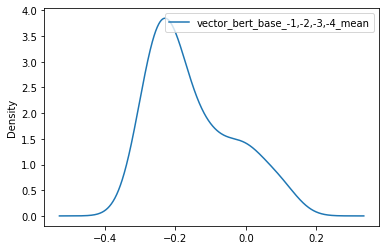

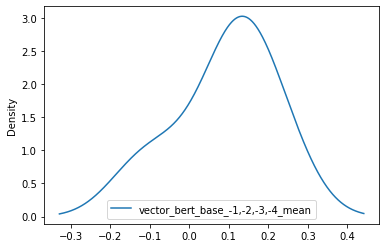

In [36]:
dfL = pd.DataFrame([sims,df_val.label]).T
dfL[dfL.label=="0"].plot(kind='density')
dfL[dfL.label=="1"].plot(kind='density')

In [37]:
df_test[f"bert_contrast_{vector_type}"] = df_test[vector_type].progress_apply(wsd.bert_semaxis_vector, sem_axis=sem_axis, return_label=True, threshold=.0)
wsd.eval(f"bert_contrast_{vector_type}",df_test)

{'1': [0.333, 0.5, 0.4], '0': [0.944, 0.894, 0.918]}

# Time sensitive

In [38]:
df_test[f"bert_ts_nn_polar_{vector_type}"] = df_test.progress_apply(wsd.bert_nn_ts_centroid_vector, df_train=df_train, axis=1)
wsd.eval(f"bert_ts_nn_polar_{vector_type}",df_test)

{'1': [0.364, 0.4, 0.381], '0': [0.935, 0.926, 0.93]}

In [39]:
df_test[f"bert_ts_nn_polar_{vector_type}"] = df_test.progress_apply(wsd.bert_ts_semaxis_vector, df_train=df_train, axis=1)
wsd.eval(f"bert_ts_nn_polar_{vector_type}",df_test)

{'1': [0.0, 0.0, 0.0], '0': [0.904, 1.0, 0.949]}

## At the sense level

In [40]:
senseid2label = dict(df_test[['sense_id','label']].values)
df_test[f"bert_centroid_sense_{vector_type}"] = df_test.progress_apply(wsd.bert_nn_ts_sense_centroid_vector,  
                        senseid2label= senseid2label,
                        df_train = df_train, axis=1)

wsd.eval(f"bert_centroid_sense_{vector_type}",df_test)


{'1': [0.5, 0.4, 0.444], '0': [0.938, 0.957, 0.947]}

# Eval at the lemma level

In [6]:

embedding_methods = {'bert_base': {"path":'bert-base-uncased',
                                   'layers':'-1,-2,-3,-4',
                                   'pooling_operation':'mean'},
                     'blert': {"path":'/deezy_datadrive/kaspar-playground/bert_model/FT_bert_base_uncased_all_books_v002',
                                    'layers':'-1,-2,-3,-4',
                                    'pooling_operation':'mean'},
                     'bert_1850':{"path":"/datadrive/khosseini/LM_with_bert_MOVED_to_another_VM_REMOVE_FROM_NOVEMBER/models/bert/FT_bert_base_uncased_before_1850_v001", 
                                    'layers':'-1,-2,-3,-4',
                                    'pooling_operation':'mean'},
                      'bert_1900': {"path":"/datadrive/khosseini/LM_with_bert_MOVED_to_another_VM_REMOVE_FROM_NOVEMBER/models/bert/FT_bert_base_uncased_after_1890_before_1900_v002",
                                    'layers':'-1,-2,-3,-4',
                                    'pooling_operation':'mean'},
                      'bert_1875': {"path":"/datadrive/khosseini/LM_with_bert_MOVED_to_another_VM_REMOVE_FROM_NOVEMBER/models/bert/FT_bert_base_uncased_after_1850_before_1875_v002",
                                    'layers':'-1,-2,-3,-4',
                                    'pooling_operation':'mean'},
                      'bert_1890': {"path":"/datadrive/khosseini/LM_with_bert_MOVED_to_another_VM_REMOVE_FROM_NOVEMBER/models/bert/FT_bert_base_uncased_after_1875_before_1890_v002",
                                    'layers':'-1,-2,-3,-4',
                                    'pooling_operation':'mean'}
                                    }


In [18]:
y_true, y_pred_bin_centr,y_pred_ts_bin_centr,y_pred_sense_centr,y_pred_semaxis,rand, token_overlap, w2v_lesk = eval_lemma('machine','NN','01',embedding_methods,vector_type='vector_bert_base_-1,-2,-3,-4_mean')


Dataframe alread contains vectors from bert_base settings
{'path': 'bert-base-uncased', 'layers': '-1,-2,-3,-4', 'pooling_operation': 'mean'}
Dataframe alread contains vectors from blert settings
{'path': '/deezy_datadrive/kaspar-playground/bert_model/FT_bert_base_uncased_all_books_v002', 'layers': '-1,-2,-3,-4', 'pooling_operation': 'mean'}
Dataframe alread contains vectors from bert_1850 settings
{'path': '/datadrive/khosseini/LM_with_bert_MOVED_to_another_VM_REMOVE_FROM_NOVEMBER/models/bert/FT_bert_base_uncased_before_1850_v001', 'layers': '-1,-2,-3,-4', 'pooling_operation': 'mean'}
Dataframe alread contains vectors from bert_1900 settings
{'path': '/datadrive/khosseini/LM_with_bert_MOVED_to_another_VM_REMOVE_FROM_NOVEMBER/models/bert/FT_bert_base_uncased_after_1890_before_1900_v002', 'layers': '-1,-2,-3,-4', 'pooling_operation': 'mean'}
Dataframe alread contains vectors from bert_1875 settings
{'path': '/datadrive/khosseini/LM_with_bert_MOVED_to_another_VM_REMOVE_FROM_NOVEMBER/mode


Using lemma_etal as evaluation mode.



machine_nn01-38476096
# senses before filtering by date = 517
# senses after filtering by date = 352


# of seed senses 22 
# of synonyms 310 
# of branch senses 0


# of seeds selected 1 
# of synonyms selected 2 
# of branches selected 0
[LOG] #rows before removing None vector (104, 25)
[LOG] #rows after removing None vector (104, 25)



Using lemma_etal as evaluation mode.



machine_nn01-38476566
# senses before filtering by date = 517
# senses after filtering by date = 352


# of seed senses 22 
# of synonyms 310 
# of branch senses 0


# of seeds selected 0 
# of synonyms selected 8 
# of branches selected 0
[LOG] #rows before removing None vector (18, 25)
[LOG] #rows after removing None vector (17, 25)



Using lemma_etal as evaluation mode.



machine_nn01-38475046
# senses before filtering by date = 517
# senses after filtering by date = 352


# of seed senses 22 
# of synonyms 310 
# of branch senses 0


# of seeds selected 1 
# of synonyms selected 9 
# of branches selected 0
[LOG] #rows before removing None vector (205, 25)
[LOG] #rows after removing None vector (204, 25)



Using lemma_etal as evaluation mode.



machine_nn01-38474548
# senses before filtering by date = 517
# senses after filtering by date = 352


# of seed senses 22 
# of synonyms 310 
# of branch senses 0


# of seeds selected 1 
# of synonyms selected 25 
# of branches selected 0
[LOG] #rows before removing None vector (671, 25)
[LOG] #rows after removing None vector (668, 25)



Using lemma_etal as evaluation mode.



machine_nn01-38476316
# senses before filtering by date = 517
# senses after filtering by date = 352


# of seed senses 22 
# of synonyms 310 
# of branch senses 0


# of seeds selected 1 
# of synonyms selected 65 
# of branches selected 0
[LOG] #rows before removing None vector (1554, 25)
[LOG] #rows after removing None vector (1544, 25)



Using lemma_etal as evaluation mode.



machine_nn01-38474607
# senses before filtering by date = 517
# senses after filtering by date = 352


# of seed senses 22 
# of synonyms 310 
# of branch senses 0


# of seeds selected 1 
# of synonyms selected 33 
# of branches selected 0
[LOG] #rows before removing None vector (699, 25)
[LOG] #rows after removing None vector (690, 25)



Using lemma_etal as evaluation mode.



machine_nn01-38474140
# senses before filtering by date = 517
# senses after filtering by date = 352


# of seed senses 22 
# of synonyms 310 
# of branch senses 0


# of seeds selected 1 
# of synonyms selected 38 
# of branches selected 0
[LOG] #rows before removing None vector (966, 25)
[LOG] #rows after removing None vector (945, 25)



Using lemma_etal as evaluation mode.



machine_nn01-38475923
# senses before filtering by date = 517
# senses after filtering by date = 352


# of seed senses 22 
# of synonyms 310 
# of branch senses 0


# of seeds selected 1 
# of synonyms selected 8 
# of branches selected 0
[LOG] #rows before removing None vector (263, 25)
[LOG] #rows after removing None vector (263, 25)



Using lemma_etal as evaluation mode.



machine_nn01-38474233
# senses before filtering by date = 517
# senses after filtering by date = 352


# of seed senses 22 
# of synonyms 310 
# of branch senses 0


# of seeds selected 1 
# of synonyms selected 1 
# of branches selected 0
[LOG] #rows before removing None vector (146, 25)
[LOG] #rows after removing None vector (146, 25)



Using lemma_etal as evaluation mode.



machine_nn01-38474405
# senses before filtering by date = 517
# senses after filtering by date = 352


# of seed senses 22 
# of synonyms 310 
# of branch senses 0


# of seeds selected 1 
# of synonyms selected 0 
# of branches selected 0
[LOG] #rows before removing None vector (99, 25)
[LOG] #rows after removing None vector (99, 25)



Using lemma_etal as evaluation mode.



machine_nn01-38475494
# senses before filtering by date = 517
# senses after filtering by date = 352


# of seed senses 22 
# of synonyms 310 
# of branch senses 0


# of seeds selected 1 
# of synonyms selected 0 
# of branches selected 0
[LOG] #rows before removing None vector (99, 25)
[LOG] #rows after removing None vector (99, 25)



Using lemma_etal as evaluation mode.



machine_nn01-38473945
# senses before filtering by date = 517
# senses after filtering by date = 352


# of seed senses 22 
# of synonyms 310 
# of branch senses 0


# of seeds selected 1 
# of synonyms selected 10 
# of branches selected 0
[LOG] #rows before removing None vector (363, 25)
[LOG] #rows after removing None vector (361, 25)



Using lemma_etal as evaluation mode.



machine_nn01-38476245
# senses before filtering by date = 517
# senses after filtering by date = 352


# of seed senses 22 
# of synonyms 310 
# of branch senses 0


# of seeds selected 0 
# of synonyms selected 14 
# of branches selected 0
[LOG] #rows before removing None vector (430, 25)
[LOG] #rows after removing None vector (425, 25)



Using lemma_etal as evaluation mode.



machine_nn01-38475099
# senses before filtering by date = 517
# senses after filtering by date = 352


# of seed senses 22 
# of synonyms 310 
# of branch senses 0


# of seeds selected 1 
# of synonyms selected 15 
# of branches selected 0
[LOG] #rows before removing None vector (311, 25)
[LOG] #rows after removing None vector (308, 25)



Using lemma_etal as evaluation mode.



machine_nn01-38475164
# senses before filtering by date = 517
# senses after filtering by date = 352


# of seed senses 22 
# of synonyms 310 
# of branch senses 0


# of seeds selected 1 
# of synonyms selected 24 
# of branches selected 0
[LOG] #rows before removing None vector (790, 25)
[LOG] #rows after removing None vector (747, 25)



Using lemma_etal as evaluation mode.



machine_nn01-38474877
# senses before filtering by date = 517
# senses after filtering by date = 352


# of seed senses 22 
# of synonyms 310 
# of branch senses 0


# of seeds selected 1 
# of synonyms selected 4 
# of branches selected 0
[LOG] #rows before removing None vector (273, 25)
[LOG] #rows after removing None vector (267, 25)



Using lemma_etal as evaluation mode.



machine_nn01-38474974
# senses before filtering by date = 517
# senses after filtering by date = 352


# of seed senses 22 
# of synonyms 310 
# of branch senses 0


# of seeds selected 1 
# of synonyms selected 6 
# of branches selected 0
[LOG] #rows before removing None vector (212, 25)
[LOG] #rows after removing None vector (211, 25)



Using lemma_etal as evaluation mode.



machine_nn01-38474097
# senses before filtering by date = 517
# senses after filtering by date = 352


# of seed senses 22 
# of synonyms 310 
# of branch senses 0


# of seeds selected 0 
# of synonyms selected 29 
# of branches selected 0
[LOG] #rows before removing None vector (766, 25)
[LOG] #rows after removing None vector (759, 25)



Using lemma_etal as evaluation mode.



machine_nn01-38475772
# senses before filtering by date = 517
# senses after filtering by date = 352


# of seed senses 22 
# of synonyms 310 
# of branch senses 0


# of seeds selected 1 
# of synonyms selected 4 
# of branches selected 0
[LOG] #rows before removing None vector (122, 25)
[LOG] #rows after removing None vector (120, 25)



Using lemma_etal as evaluation mode.



machine_nn01-38474820
# senses before filtering by date = 517
# senses after filtering by date = 352


# of seed senses 22 
# of synonyms 310 
# of branch senses 0


# of seeds selected 1 
# of synonyms selected 2 
# of branches selected 0
[LOG] #rows before removing None vector (116, 25)
[LOG] #rows after removing None vector (116, 25)



Using lemma_etal as evaluation mode.



machine_nn01-38476397
# senses before filtering by date = 517
# senses after filtering by date = 352


# of seed senses 22 
# of synonyms 310 
# of branch senses 0


# of seeds selected 1 
# of synonyms selected 0 
# of branches selected 0
[LOG] #rows before removing None vector (99, 25)
[LOG] #rows after removing None vector (99, 25)



Using lemma_etal as evaluation mode.



machine_nn01-38475013
# senses before filtering by date = 517
# senses after filtering by date = 352


# of seed senses 22 
# of synonyms 310 
# of branch senses 0


# of seeds selected 1 
# of synonyms selected 4 
# of branches selected 0
[LOG] #rows before removing None vector (182, 25)
[LOG] #rows after removing None vector (179, 25)



Using lemma_etal as evaluation mode.



machine_nn01-38474301
# senses before filtering by date = 517
# senses after filtering by date = 352


# of seed senses 22 
# of synonyms 310 
# of branch senses 0


# of seeds selected 1 
# of synonyms selected 3 
# of branches selected 0
[LOG] #rows before removing None vector (152, 25)
[LOG] #rows after removing None vector (152, 25)



Using lemma_etal as evaluation mode.



machine_nn01-38475286
# senses before filtering by date = 517
# senses after filtering by date = 352


# of seed senses 22 
# of synonyms 310 
# of branch senses 0


# of seeds selected 1 
# of synonyms selected 6 
# of branches selected 0
[LOG] #rows before removing None vector (265, 25)
[LOG] #rows after removing None vector (264, 25)



Using lemma_etal as evaluation mode.


In [19]:
print(classification_report(y_true, rand))

              precision    recall  f1-score   support

           0       0.90      0.51      0.65      1616
           1       0.09      0.48      0.16       170

    accuracy                           0.50      1786
   macro avg       0.50      0.49      0.40      1786
weighted avg       0.83      0.50      0.60      1786



In [20]:
print(classification_report(y_true, token_overlap))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90      1616
           1       0.19      0.28      0.23       170

    accuracy                           0.82      1786
   macro avg       0.56      0.58      0.56      1786
weighted avg       0.85      0.82      0.83      1786



In [21]:
print(classification_report(y_true, y_pred_bin_centr))

              precision    recall  f1-score   support

           0       0.96      0.80      0.87      1616
           1       0.25      0.66      0.37       170

    accuracy                           0.78      1786
   macro avg       0.61      0.73      0.62      1786
weighted avg       0.89      0.78      0.82      1786



In [22]:
print(classification_report(y_true, y_pred_ts_bin_centr))

              precision    recall  f1-score   support

           0       0.94      0.84      0.88      1616
           1       0.23      0.46      0.31       170

    accuracy                           0.80      1786
   macro avg       0.58      0.65      0.60      1786
weighted avg       0.87      0.80      0.83      1786



In [23]:
print(classification_report(y_true, y_pred_sense_centr ))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96      1616
           1       0.59      0.45      0.51       170

    accuracy                           0.92      1786
   macro avg       0.77      0.71      0.73      1786
weighted avg       0.91      0.92      0.91      1786



In [24]:
print(classification_report(y_true,y_pred_semaxis ))

              precision    recall  f1-score   support

           0       0.96      0.69      0.80      1616
           1       0.20      0.73      0.31       170

    accuracy                           0.70      1786
   macro avg       0.58      0.71      0.56      1786
weighted avg       0.89      0.70      0.76      1786

